<a href="https://colab.research.google.com/github/TaigoKuriyama/national_park_prediction/blob/master/notebook/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

In [2]:
import pandas as pd
from sklearn.cross_validation import train_test_split
import math
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [0]:
# tsv to Dataframe
df_train = pd.read_csv('train.tsv',sep='\t')
df_test = pd.read_csv('test.tsv',sep='\t')

In [0]:
# Feature engineering from datetime
# https://adtech.cyberagent.io/techblog/archives/259
# https://note.nkmk.me/python-pandas-datetime-timestamp/
def create_date_future(df):
    df['datetime'] = pd.to_datetime(df['datetime']) # dtypeをdatetime64に変換
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek  

In [5]:
create_date_future(df_train)
create_date_future(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3
2,2015-01-01,日光国立公園,29714,2015,1,1,3
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3


In [0]:
# label encoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

def onehot_encdr_park(df):
    le = preprocessing.LabelEncoder()
    le.fit(df['park'])
    le.transform(['阿寒摩周国立公園', '十和田八幡平国立公園', '日光国立公園', '伊勢志摩国立公園','大山隠岐国立公園','阿蘇くじゅう国立公園', '霧島錦江湾国立公園', '慶良間諸島国立公園']) 
    
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['park'])
    df_park = pd.DataFrame(park_onehot,columns=le.classes_)
    df = pd.concat([df,df_park],axis=1)
    return df

In [7]:
df_train = onehot_encdr_park(df_train)
df_test = onehot_encdr_park(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,0,0,1,0,0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,0,0,0,0,0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,0,1,0,0,0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,0,0,0,0,0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,0,0,0,0,0


In [0]:
def onehot_encdr_dayofweek(df):
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['dayofweek'])
    df_park = pd.DataFrame(park_onehot,columns=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    df = pd.concat([df,df_park],axis=1)
    return df

In [9]:
df_train = onehot_encdr_dayofweek(df_train)
df_test = onehot_encdr_dayofweek(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [16]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

### データから特徴量作成

In [15]:
# holiday data include Saturday, Sunday
df_holiday = pd.read_csv('holiday.csv')
df_holiday['datetime'] = pd.to_datetime(df_holiday['datetime'])

Saving holiday.csv to holiday.csv


In [18]:
# holiday data exclude Saturday, Sunday
df_holiday_exc_wkend = pd.read_csv('holiday.csv')
df_holiday_exc_wkend['datetime'] = pd.to_datetime(df_holiday_exc_wkend['datetime'])
df_holiday_exc_wkend['dayofweek'] = df_holiday_exc_wkend['datetime'].dt.dayofweek

# dayofweekが5 or 6(土曜or日曜)の場合、holidayカラムの値を0にする
df_holiday_exc_wkend.loc[(df_holiday_exc_wkend['dayofweek'] == 5) | (df_holiday_exc_wkend['dayofweek'] == 6), 'holiday'] = 0
df_holiday_exc_wkend = df_holiday_exc_wkend[['datetime','holiday']]
df_holiday_exc_wkend = df_holiday_exc_wkend.rename(columns={'holiday': 'pub_holiday'})
df_holiday_exc_wkend.head()

,datetime,pub_holiday
0,2015-01-01,1
1,2015-01-02,0
2,2015-01-03,0
3,2015-01-04,0
4,2015-01-05,0


In [19]:
# 防災科学技術研究所 ⼤⼭鏡ヶ成積雪気象観測施設における積雪気象観測データ
# 日ごとの積雪量の平均データを作成
df_nied_oyama = pd.read_csv('nied_oyama.tsv',sep='\t')
df_nied_oyama['日時'] = pd.to_datetime(df_nied_oyama['日時'])
df_nied_oyama['日時'] = df_nied_oyama['日時'].dt.strftime('%Y-%m-%d')
df_nied_oyama_mean = df_nied_oyama.groupby('日時',as_index=False).mean()[['日時','積雪深(cm)', '気温(℃)']]
df_oyama = df_nied_oyama_mean.assign(大山隠岐国立公園=1)
df_oyama = df_oyama.rename(columns={'日時': 'datetime'})
df_oyama.head()

FileNotFoundError: ignored

# sin cos curve

In [0]:
N = 365 # データ数
N_ = 366
n = np.arange(365)
n_ = np.arange(366)

#  Not leap year
sin_cur_not_leap= np.sin(2*np.pi*n/N)
cos_cur_not_leap= np.cos(2*np.pi*n/N)

#  leap year
sin_cur_leap= np.sin(2*np.pi*n_/N_)
cos_cur_leap= np.cos(2*np.pi*n_/N_)

# concat for 2015, 2016
sin_cur = np.concatenate((sin_cur_not_leap, sin_cur_leap), axis=0)
cos_cur = np.concatenate((cos_cur_not_leap, cos_cur_leap), axis=0)

# to dataframe
sin_columns = 'sin'
df_sin_cur_train = pd.DataFrame(data=sin_cur,dtype='float')
df_cos_cur_train = pd.DataFrame(data=cos_cur,dtype='float')

# concat for 2017
df_sin_cur_test = pd.DataFrame(data=sin_cur_not_leap,dtype='float')
df_cos_cur_test = pd.DataFrame(data=cos_cur_not_leap,dtype='float')

In [0]:
df_weather = pd.read_csv('../data/raw/weather.tsv',sep='\t')
df_weather.head()

In [0]:
df_weather = pd.read_csv('../data/raw/weather.tsv',sep='\t')
df_weather['日時'] = pd.to_datetime(df_weather['年月日'])
df_weather_mean = df_weather.groupby('日時',as_index=False).mean()[['日時','積雪深(cm)', '気温(℃)']]

### 作成した特徴量と学習データの結合

In [40]:
# 学習データと休日データの結合
#df_merged = pd.merge(df_train,df_holiday,on='datetime') # 
df_merged = pd.merge(df_train,df_holiday_exc_wkend,on='datetime')
#df_merged =  pd.merge(df_merged,df_holiday_exc_wkend,on='datetime')

# 学習データと⼤⼭気象データの結合
#df_oyama['datetime'] = pd.to_datetime(df_oyama['datetime'])
#df_merged = pd.merge(df_merged,df_oyama,on=['大山隠岐国立公園','datetime'],how='left')

# 学習データとsin/cosカーブデータの結合
df_datetime_train = df_train[~df_train.duplicated(subset='datetime')]['datetime']
df_datetime_train = df_datetime_train.reset_index()
df_datetime_train = df_datetime_train['datetime']
df_sin_cos = pd.concat([df_datetime_train,df_sin_cur_train,df_cos_cur_train], axis=1)
df_sin_cos.columns = ['datetime', 'sin', 'cos']
df_merged = pd.merge(df_merged,df_sin_cos,on='datetime')
df_merged.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,1,0,0,0,1,0.0,1.0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,1,0,0,0,1,0.0,1.0


In [0]:
from sklearn.cross_validation import train_test_split
import math
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

In [23]:
df_except_y = df_merged.drop(['park','visitors','datetime'], axis=1)
X_train = df_except_y.as_matrix() 
y_train = df_merged['visitors'].as_matrix()
df_except_y.head()

,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,...,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos
0,2015,1,1,3,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0.0,1.0
1,2015,1,1,3,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0
2,2015,1,1,3,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0.0,1.0
3,2015,1,1,3,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0
4,2015,1,1,3,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0.0,1.0


### 作成した特徴量とテストデータの結合

In [25]:
# holidayデータとのマージ
#df_test_merged = pd.merge(df_test,df_holiday,on='datetime')
df_test_merged = pd.merge(df_test,df_holiday_exc_wkend,on='datetime')
#df_test_merged = pd.merge(df_test_merged,df_holiday_exc_wkend,on='datetime')
#df_test_merged = pd.merge(df_test_merged,df_oyama,on=['大山隠岐国立公園','datetime'],how='left')

# sin/cosカーブデータとのマージ
df_datetime_test = df_test[~df_test.duplicated(subset='datetime')]['datetime']
df_datetime_test = df_datetime_test.reset_index()
df_datetime_test = df_datetime_test['datetime']
df_sin_cos_test = pd.concat([df_datetime_test,df_sin_cur_test,df_cos_cur_test], axis=1)
df_sin_cos_test.columns = ['datetime', 'sin', 'cos']
df_test_merged = pd.merge(df_test_merged,df_sin_cos_test,on='datetime')
df_test_merged = df_test_merged.drop(['park','datetime','index'], axis=1)
df_test_merged = df_test_merged.fillna(0)
X_test = df_test_merged.as_matrix()
df_test_merged.head()

,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,...,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos
0,2017,1,1,6,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0.0,1.0
1,2017,1,1,6,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0.0,1.0
2,2017,1,1,6,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0.0,1.0
3,2017,1,1,6,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.0,1.0
4,2017,1,1,6,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0.0,1.0


### モデル作成

In [0]:
# parametar tuning
params = {"learning_rate":[0.1,0.3,0.5],
        "max_depth": [2,3,5,10],
         "subsample":[0.5,0.8,0.9,1],
         "colsample_bytree": [0.5,1.0],
         }

model = xgb.XGBRegressor()
cv = GridSearchCV(model,params,cv=10,n_jobs=-1)

In [0]:
# Cross Validation
from sklearn.model_selection import train_test_split
# train：validation = 3：１
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train, random_state=0)

In [29]:
# model
cv.fit(X_train_cv, y_train_cv)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [2, 3, 5, 10], 'subsample': [0.5, 0.8, 0.9, 1], 'colsample_bytree': [0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [32]:
# predict
y_test_pred = cv.predict(X_test_cv)
y_train_pred = cv.predict(X_train_cv)

# 評価
from sklearn.metrics import mean_absolute_error
print('MAE test：{0}'.format(mean_absolute_error(y_test_cv, y_test_pred)))
print('MAE train：{0}'.format(mean_absolute_error(y_train_cv, y_train_pred)))

MAE test：1630.9984953020241
MAE train：903.9336502896668


### 誤差分析
Residuals：残差(誤差の推定量)

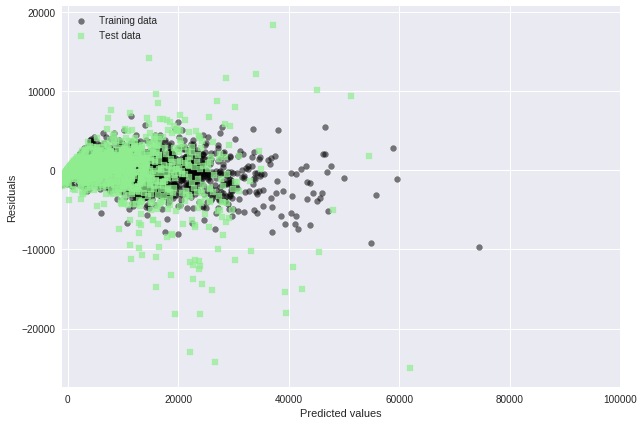

In [42]:
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plot
plt.figure(figsize = (10, 7))
plt.scatter(y_train_pred, y_train_pred - y_train_cv, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test_cv, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
plt.xlim([-1000, 100000])
plt.show()

In [34]:
# model
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [2, 3, 5, 10], 'subsample': [0.5, 0.8, 0.9, 1], 'colsample_bytree': [0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [37]:
# 
reg = xgb.XGBRegressor(**cv.best_params_)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [0]:
# 学習モデルの保存、読み込み
import pickle
#pickle.dump(reg, open("../model/model_8.pkl", "wb"))
reg = pickle.load(open("../model/model_8.pkl", "rb"))

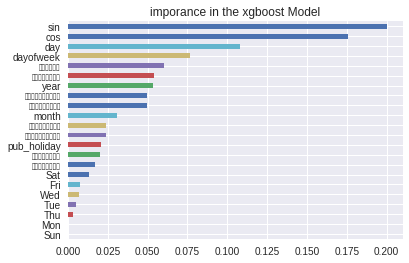

In [38]:
# future importance
import pandas as pd
import matplotlib.pyplot as plt
importances = pd.Series(reg.feature_importances_, index = df_except_y.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

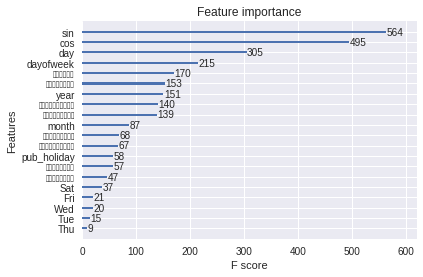

In [39]:
features =df_except_y.columns[df_except_y.any()]
mapper = {'f{0}'.format(i): v for i, v in enumerate(features)}
mapped = {mapper[k]: v for k, v in reg._Booster.get_fscore().items()}
xgb.plot_importance(mapped)

In [0]:
# predict
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [0]:
# create submit file
df_submit = pd.DataFrame({
    '':df_test['index'],
    '':y_test_pred})
# pandas.[DataFrame or Series].where(cond,other=xxx) condがFalseの時にotherを代入
# マイナスと予測した結果を０に修正
df_submit.where(df_submit.iloc[:, [0]] > 0, 0).head()

In [0]:
submit.to_csv('../submit/submit_8.tsv',sep='\t')
df_train = pd.read_csv('../data/raw/train.tsv',sep='\t')
